<a href="https://colab.research.google.com/github/gmp007/Machine-Learning-and-EDA-Exploratory-Data-Analysis-Projects/blob/main/MovieRecommender/MovieRecommenderModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents 
[Libraries Used](#libraries) 

Part I: [About Dataset](#aboutdataset)

Part II: [Summary of Problem and Task](#task)

Part III: [Getting the Dataset](#getdata)

Part IV: [Data Preprocessing](#cleanup) 

Part V: [Exploratory Data Analysis and Visualization](#eda)

Part VI: [Model Design and Model Training](#model)

Part VII: [Model Evaluation and Performance](#makeprediction)

Part VIII: [Hyperparameter Optimization](#hyperparameter)

Part IX: [Summary](#summary)

<a id='libraries'></a>

# Import Essential Libraries

In [1]:
# General libraries
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt 
import seaborn as sns
import string
from scipy.stats import loguniform
import csv
import requests
import tarfile

# NLP libraries
from nltk.corpus import stopwords
import nltk
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

# Model Building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity


#import the required libraries for grid search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold,StratifiedKFold,KFold

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer 

# Performance metric
from sklearn.metrics import f1_score


import warnings

random_seed = 121
test_size = 0.20
hyperparameter =False

%matplotlib inline
pd.set_option('display.max_colwidth', 300)
warnings.filterwarnings("ignore")
# nltk needed below. Download it here
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<a id='aboutdataset'></a>

# Part I: About the Datasets
This is the famous IMDB dataset. Data is accessed from the URLs below:

- [IMDB Static Datasets - https://datasets.imdbws.com/](https://datasets.imdbws.com/)
- [IMDB Data Definition Details - https://www.imdb.com/interfaces/](https://www.imdb.com/interfaces/)
- [IMDB Spoiler Dataset - https://www.kaggle.com/rmisra/imdb-spoiler-dataset/data](https://www.kaggle.com/rmisra/imdb-spoiler-dataset/data)
- [CMU Plot Summary Data Set - http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz](http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz)

<a id='task'></a>

# Part II: Summary of Problem and Task

<a id='getdata'></a>

## **Task**
- Use data-driven machine learning modeling to classify movie genres and recommend similar films for new movie production company's internal review and assessment based on lightning pitch synopses.

## **Input**

- The system should accept a text file containing a movie synopsis as input. The text file should be in plain text format and include a description of the movie's plot, characters, and other relevant details.

## **Output**
- The system should return the primary genre of the movie, or multiple genres if more than one scores equally high. The output should be a list of genre(s) that best describe the movie based on its synopsis.

- Additionally, the system will return a list of no more than five similar movies based on the synopsis provided. The list will include movie titles and a brief description of each movie.

## **Genre Derivation**
- The list of applicable genres will be derived from the data provided during training. The system will use advanced natural language processing techniques to determine the genre of a movie based on its synopsis.

## **Multiple Genres**
- A movie can belong to more than one genre, but the system believes that movies should fit in a given genre more than another. If a movie belongs to multiple genres equally, the system will return all relevant genres in the output.

## **What the Model is Intended to Achieve**
- This system is designed to help moviegoers and experts in quickly determining the genre of a film and finding related films based on its description. The system's powerful natural language processing capabilities provide reliable findings, making it a great tool for anybody interested in film analysis.

<a id='getdata'></a>

# Part III: Getting the Dataset

In [2]:
url = "http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz"
response = requests.get(url, stream=True)
file = tarfile.open(fileobj=response.raw, mode="r|gz")
file.extractall(path=".")

In [3]:
!cp MovieSummaries/* .

In [4]:
meta_data = pd.read_csv("movie.metadata.tsv", sep = '\t', header = None)
meta_data.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


<a id='cleanup'></a>

# Part IV: Data Preprocessing

In [5]:
# The data has no head. So, use documentation to assign essential headers
# rename columns
meta_data.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"movie_genre"]

In [6]:
# Load the plot summary
plots_sum = []

with open("plot_summaries.txt", 'r') as f:
       reader_plot_sum = csv.reader(f, dialect='excel-tab') 
       for row in tqdm(reader_plot_sum):
            plots_sum.append(row)

42303it [00:03, 12751.68it/s]


In [7]:
#Next, split the movie ids and the plots into two separate lists. I will use these lists to form a dataframe
movie_id = []
MovieSynopsis = []

# extract movie Ids and plot summaries
for i in tqdm(plots_sum):
  movie_id.append(i[0])
  MovieSynopsis.append(i[1])

# Create the Dataframe
movies = pd.DataFrame({'movie_id': movie_id, 'MovieSynopsis': MovieSynopsis})

100%|██████████| 42303/42303 [00:00<00:00, 530495.49it/s]


In [8]:
# Add the movie genres and names
# change datatype of 'movie_id'
meta_data['movie_id'] = meta_data['movie_id'].astype(str)

# merge meta with plot data
movies = pd.merge(movies, meta_data[['movie_id', 'movie_name', 'movie_genre']], on = 'movie_id')

movies.head()

,movie_id,MovieSynopsis,movie_name,movie_genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}"


<a id='eda'></a>

# Part V: Exploratory Data Analysis, Visualization, and Pre-processing

In [9]:
#The movie genres are in a dictionary notation. 
#Convert them to Python list
# an empty list
genres = [] 

# extract genres
for i in movies['movie_genre']: 
  genres.append(list(json.loads(i).values())) 

# add to 'movies' dataframe  
movies['new_movie_genre'] = genres

In [10]:
movies.head(5)

,movie_id,MovieSynopsis,movie_name,movie_genre,new_movie_genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}","[Drama, World cinema]"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}","[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}","[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}","[Screwball comedy, Comedy]"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}","[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


In [11]:
# Some movies have zero genre entry. Remove these entries with no genre
movies_new = movies[~(movies['new_movie_genre'].str.len() == 0)]

In [12]:
#Compare the two:
movies.shape, movies_new.shape # About 411 has no genres
print("Movies with zero genre",(movies.shape[0] -movies_new.shape[0]))

Movies with zero genre 411


In [13]:
# Check the number of genre tags in the dataset
all_genres = sum(genres,[])
len(set(all_genres))

363

In [14]:
# Check the genre tags
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

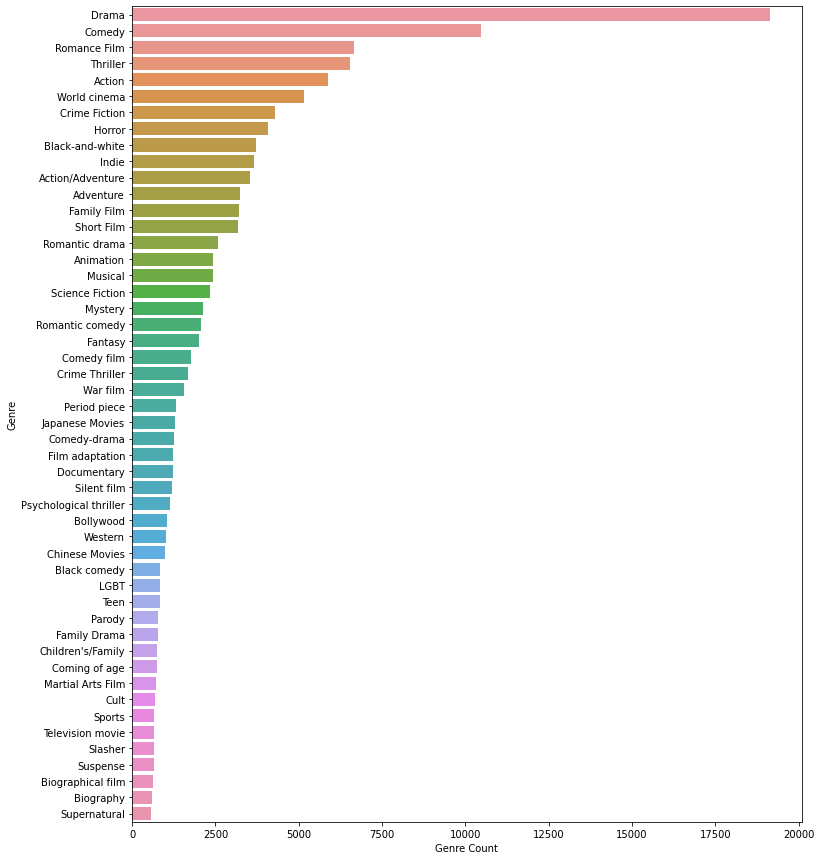

In [15]:
# Plot the genres:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Genre') 
ax.set(xlabel = 'Genre Count') 
plt.show()

In [16]:
# Further data cleaning 
stop_words = set(stopwords.words('english'))


def clean_text_and_remove_stopwords(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    # remove stopwords
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies_new['Clean_MovieSynopsis'] = movies_new['MovieSynopsis'].apply(lambda x: clean_text_and_remove_stopwords(x))

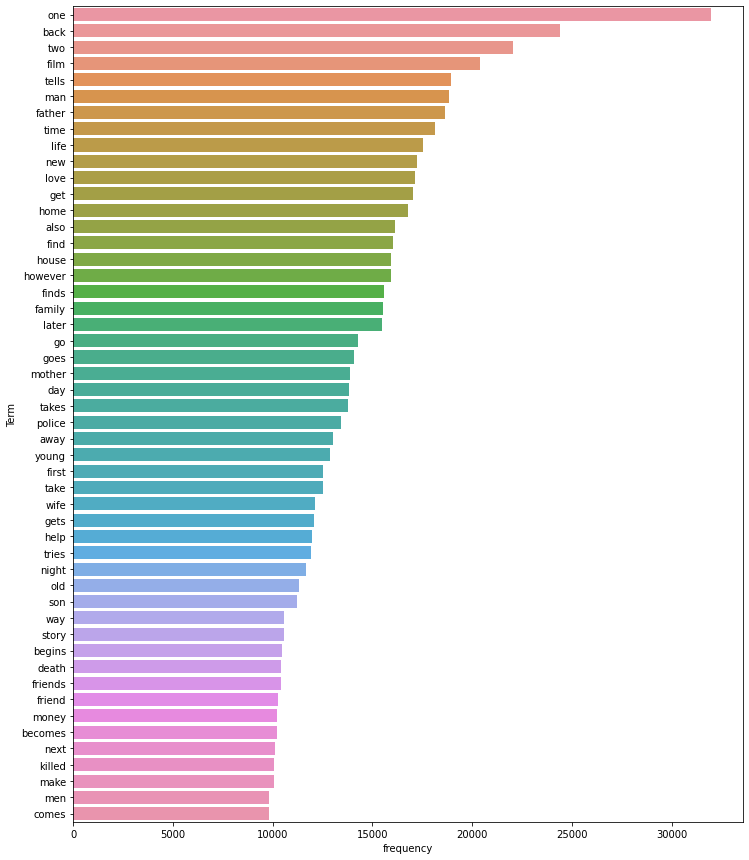

In [17]:
def top_frequent_terms(data, max_terms=50):
  all_text = ' '.join(data)
  tokens = all_text.split()
  word_freq = nltk.FreqDist(tokens)
  term_df = pd.DataFrame({'term':list(word_freq.keys()), 'frequency':list(word_freq.values())})

  top_terms = term_df.nlargest(columns='frequency', n=max_terms)

  plt.figure(figsize=(12,15))
  plot = sns.barplot(data=top_terms, x='frequency', y='term')
  plot.set(ylabel='Term')
  plt.show()

# print 50 most frequent words in a genre 
top_frequent_terms(movies_new['Clean_MovieSynopsis'], 50)

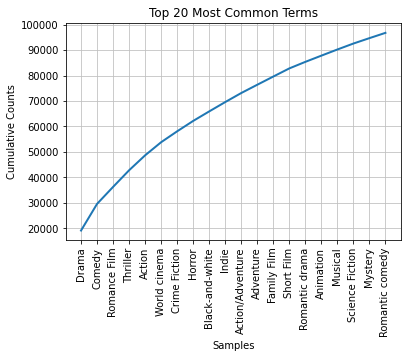

In [18]:
# Plot the cummulative frequency curve of the genres
plt.title('Top 20 Most Common Terms')
all_genres.plot(20,cumulative=True)
plt.show()

<a id='model'></a>

# Model Design and Model Training

In [19]:
# Convert the text to features
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['new_movie_genre']) 

# transform target variable
y = multilabel_binarizer.transform(movies_new['new_movie_genre'])

In [20]:
# Using TF-IDF to extract features 
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000, analyzer='word',min_df=0, stop_words='english') # Check other vectorizers
# I have used 10,000 most frequent words in the data as my features

In [21]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(movies_new['Clean_MovieSynopsis'], y, test_size=test_size, random_state=random_seed)

In [22]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [23]:
#Define the model.The dataset has about 363 labels (genres); I have used OneVsRestClassifier for multiclass handling  
model = OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000,random_state=random_seed,n_jobs=-1))

In [24]:
# Fit the training set
model.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                                 random_state=121))

<a id='makeprediction'></a>

# Model Evaluation and Performance

In [25]:
# Make some predictions
y_pred = model.predict(xval_tfidf)

In [26]:
# Note this output will be in one-hot encoder of the dim of the dataset
y_pred[4]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [27]:
# Use inverse transform to convert the one-hot encoded data to the unique genre and compare with the actual genre
print("-"*35)
print("The predicted genre is", multilabel_binarizer.inverse_transform(y_pred)[4], "\nThe Actual Genre is",multilabel_binarizer.inverse_transform(yval)[4])
print("-"*35)

-----------------------------------
The predicted genre is ('Drama',) 
The Actual Genre is ('Drama', 'Short Film')
-----------------------------------


In [28]:
# Define a function to evaluate the model accuracy based on the f1 score
def evaluate_model(model, xvalue, yvalue, thr=0.35):
  y_pred_prob = model.predict_proba(xvalue)
  y_pred = (y_pred_prob >= thr).astype(int)
  f1 = f1_score(yvalue, y_pred, average="micro")
  #print("The micro-average quality for threshold=", thr)
  print("-"*40)
  print(" The micro F1-score of model is: {:.4f}".format(f1))
  print("-"*40)

In [29]:
evaluate_model(model, xval_tfidf, yval)

----------------------------------------
 The micro F1-score of model is: 0.4161
----------------------------------------


## The model achieved micro F-1 socre that is greater than the baseline F-1 score of 0.35. Now, I will proceed to handle the main requirement of the model as outlined below:

- The movie genre prediction system should be capable of handling new movie plots in raw form as input and generating its corresponding genre tag(s), and predict the top ("n, here 5") related movies to the prediction. This will enable to maintain the effectivenss of the model and adapt to future data.

**To achieve this, I defined the inference function below**

In [30]:
def predict_and_print_genres(xval, movies_new, model, tfidf_vectorizer, binarizer, nrangemovie, n_related):
    def predict_genres(text, model, vectorizer, binarizer):
        cleaned_text = clean_text_and_remove_stopwords(text)
        text_vector = vectorizer.transform([cleaned_text])
        prediction = model.predict(text_vector)
        return binarizer.inverse_transform(prediction)

    def get_related_movies(text, movies_new, vectorizer):
        cleaned_text = clean_text_and_remove_stopwords(text)
        text_vector = vectorizer.transform([cleaned_text])
        cosine_similarities = cosine_similarity(text_vector, vectorizer.transform(movies_new['movie_name']))
        related_movie_indices = cosine_similarities.argsort()[0][::-1][1:n_related+1]
        related_movies = movies_new.iloc[related_movie_indices]['movie_name'].values
        return related_movies, cosine_similarities[0][related_movie_indices]

    for i in range(nrangemovie):
        random_index = xval.sample(1).index[0]
        print("-"*35)
        print("Name of Movie: ", movies_new['movie_name'][random_index])
        print("-"*35)
        print("Predicted Genre(s): ", predict_genres(xval[random_index], model, tfidf_vectorizer, binarizer))
        print("Actual Genre(s): ", movies_new['new_movie_genre'][random_index])
        related_movies, similarity_scores = get_related_movies(xval[random_index], movies_new, tfidf_vectorizer)
        related_movies_df = pd.DataFrame({'Related Movies': list(related_movies), 'Similarity Scores': similarity_scores})
        print("\n{}\nTop {} Related Movies to prediction:\n{}\n{}".format("-"*35, n_related, "-"*35, related_movies_df))
        print("\n")


In [36]:
# Make the prediction and also predict the top 5 related movie genres. I have additional printed out the similarity score
nrangemovie = 1; related_movies=5
predict_and_print_genres(xval, movies_new, model, tfidf_vectorizer, multilabel_binarizer,nrangemovie,related_movies)

-----------------------------------
Name of Movie:  Eun-Gyo
-----------------------------------
Predicted Genre(s):  [('Drama',)]
Actual Genre(s):  ['Romance Film', 'Drama']

-----------------------------------
Top 5 Related Movies to prediction:
-----------------------------------
            Related Movies  Similarity Scores
0      The Blood of a Poet           0.343505
1    The Poet and the Bear           0.320501
2                  The Web           0.310371
3  Kisna: The Warrior Poet           0.295609
4               Poet's Pub           0.292669




<a id='hyperparameter'></a>

# Part VIII: Hyperparameter Optimization 
- Check to see if hyperparameter optimization of the parameters improves the overall accuracy of the model. 
- ***Note*** - The hperparameter optimization part is expensive and only need to be ran once. For now, it is not needed unless new dataset is included.

In [37]:
# Define search space for the hyper parameters
space = dict()
space['estimator__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['estimator__penalty'] = ['l2']
space['estimator__C'] = loguniform(1e-5, 10)

In [38]:
if(hyperparameter == True):
    clf = OneVsRestClassifier(estimator = LogisticRegression(max_iter=500,C=1,penalty='l2',tol=0.001,random_state=random_seed))
    #define the number of folds 
    folds = KFold(n_splits=5, shuffle = True, random_state = random_seed)
    # define search
    grid_search = RandomizedSearchCV(estimator=clf,param_distributions=space, n_iter=1000, 
                                     scoring='f1_micro',verbose=3,
                                     n_jobs=-1, cv=folds.split(xtrain_tfidf,ytrain), random_state=random_seed)
    #fit grid search on the train data
    grid_result = grid_search.fit(xtrain_tfidf, ytrain)

In [39]:
#Determine the best model 
if(hyperparameter == True):
  grid_result.best_estimator_
  # Determine the f1 score:
  grid_result.cv_results_
  #Check with above if it works well
  f1_score(grid_result.predict(xval_tfidf), yval,average="micro")

In [40]:
if(hyperparameter == True):
  #Instantiate the ML with the best model
  #clf = OneVsRestClassifier(estimator = LogisticRegression(**grid_result.best_params_))
  optimized_model = grid_result.best_estimator_
  optimized_model.fit(xtrain_tfidf, ytrain)
  evaluate_model(optimized_model, xval_tfidf, yval, 0.35)
  predict_and_print_genres(optimized_model, movies_new, model, tfidf_vectorizer, multilabel_binarizer)

<a id='summary'></a>

# Part IX: Summary

**Key Inference from ML Model** 
The predicted micro F-1 score is 0.42, which is approximately 10% better than the baseline F-1 micro scores of 0.35.

# End